In [246]:
# Generic Comment
#* Important Comment
#! Warning
#? Suggestion
#TODO Todo list

import time
start_time = time.time()
import cyipopt
import math
import matplotlib.pyplot as plt
import numpy as np
from cyipopt import minimize_ipopt
from phe import paillier
from numba import *

def compute_index(indices, dims):
    if len(indices) == 1:
        return indices[0]
    else:
        current_index = indices[0]
        remaining_dims_product = 1
        for dim in dims[1:]:
            remaining_dims_product *= dim
        return current_index * remaining_dims_product + compute_index(indices[1:], dims[1:])
        
end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to import Modules = %f seconds " % total_runtime)

Total time required to import Modules = 0.000000 seconds 


# Encrypted Lyapunov Economic Model Predictive Control(LEMPC) of a Continuous Stirred Tank Reactor(CSTR)

In this code, we will apply Encrypted LEMPC to a CSTR to optimize the operation of the system based on our defined Economic model.

Note that in this design, the LEMPC is solved in the unencrypted space, but all signals are transmitted as encrypted signals, and decrpyted only when non-linear computation is needed.

## Encryption

Before encrypting a value, we first need to map it to the following quantized set:
\begin{align*}
\mathbb{Q}_{l_1,d}=\{x\in\mathbb{Q}\vert{}-2^{l_1-d-1}\leq{x}\leq{}2^{l_1-d-1}-2^{-d},\exists{k}\in\mathbb{Z}:x=k\times2^{-d}\}
\end{align*}

This is done via a function: 
\begin{align*}
g_{l_1,d}&:\mathbb{R}\rightarrow\mathbb{Q}_{l_1,d} \\
g_{l_1,d}(a)&:=\arg\min_{q\in{\mathbb{Q}_{l_1,d}}}\lvert{a-q}\rvert
\end{align*}

The Pallier Encryption Scheme only applies to $x\in\mathbb{Z}_n$ where $2^{n_{length}-1}\leq{n}<2^{n_{length}}-1$, with a function:
\begin{align*}
f_{l_2,d}&:\mathbb{Q}_{l_1,d}\rightarrow\mathbb{Z}_{2^{l_2}} \\
f_{l_2,d}(q)&:=2^dq{\bmod{}}2^{l_2}
\end{align*}

Because we define the key-length to be `n_length=128`, we say that $0\leq{x}\leq{2^{l_2}}<n$, i.e. $l_1\leq{l_2}<2^{n_{length}-1}$

Thus, we can simply say $l_2=l_1$, but we must ensure that $l_1<n_{length}$

Because of how the modulus operation works on negative numbers, and because we include 0 but exclude the upper bound while including the lower bound in our quantized set, all negative values will be at or above the median element of this set. Thus, we can invert the bijective mapping via:
\begin{align*}
f_{l_2,d}^{-1}&:\mathbb{Z}_{2^{l_2}}\rightarrow\mathbb{Q}_{l_1,d} \\
f_{l_2,d}^{-1}(m)&:=\frac{1}{2^d}\begin{cases} m-2^{l_2} & m\geq{2^{l_2-1}} \\ m & \text{otherwise}  \end{cases}
\end{align*}

In [247]:
start_time = time.time()
public_key, private_key = paillier.generate_paillier_keypair(n_length=256)
d1=10
def encrypt(val):
    return public_key.encrypt(val,precision = 2**(-d1))
def decrypt(val):
    return private_key.decrypt(val)


end_time = time.time()
total_runtime = end_time - start_time
print(
    "Total time required to initialize Encryption dependencies = %f seconds "
    % total_runtime
)

Total time required to initialize Encryption dependencies = 0.011662 seconds 


![EMPC_Diagram](EMPC_Diagram.png "lol")

In [248]:
start_time = time.time()
######### Simulation time #########################

delta = 1e-2  # hr Sampling Time
hc = 1e-4  # hr Numerical Integration Step Size
tFinal = 5  # hr Total Simulation Time(including multiple runs)

###################################### MPC simulation constants ##############################################

netTimeSteps = int( tFinal / hc)  # Number of calculated steps


controlStepSize   = 100 # Integration Steps per MPC Control Step
setpointStepSize  = 5 # Integration Steps per Set-Point        
PIcontrolStepSize = 5   # Integration Steps per PI Control Step

NUM_MPC_ITERATION = int(netTimeSteps/controlStepSize)  # Number of times simulation is run
HORIZON_LENGTH = 20

netControlTimeSteps   = int( netTimeSteps / controlStepSize   )
netSetPointTimeSteps  = int( netTimeSteps / setpointStepSize  )
netPIControlTimeSteps = int( netTimeSteps / PIcontrolStepSize )

controlTimeStepsPerMPC   = int( HORIZON_LENGTH * netControlTimeSteps   / NUM_MPC_ITERATION )
setpointTimeStepsPerMPC  = int( HORIZON_LENGTH * netSetPointTimeSteps  / NUM_MPC_ITERATION )
PIControlTimeStepsPerMPC = int( HORIZON_LENGTH * netPIControlTimeSteps / NUM_MPC_ITERATION )
timeStepsPerMPC          = int( HORIZON_LENGTH * netTimeSteps          / NUM_MPC_ITERATION )

controlTimeStepsPerControlAction   = int( netControlTimeSteps   / NUM_MPC_ITERATION )
setpointTimeStepsPerControlAction  = int( netSetPointTimeSteps  / NUM_MPC_ITERATION )
PIControlTimeStepsPerControlAction = int( netPIControlTimeSteps / NUM_MPC_ITERATION )
timeStepsPerControlAction          = int( netTimeSteps          / NUM_MPC_ITERATION )

NUM_OUTPUTS = 2  # Model Outputs: x1 x2
NUM_INPUTS = 4  # Model  Inputs: u1 u2 x1 x2
NUM_U = int(NUM_INPUTS - NUM_OUTPUTS)  # Number of control inputs


NUM_MPC_INPUTS = int(NUM_U * controlTimeStepsPerMPC)  # 1 set of control inputs per Horizon
NUM_MPC_CONSTRAINTS = controlTimeStepsPerMPC  # Constraints must be satisfied at all points

################### P matrix #############################
# V= xTP(x) "Energy of Sys"

a = 1060
b = 22
d = 0.52

###########Q Matrices for Cost Function##############
# Qx=np.diag(np.tile([2e3, 1], int(NUM_OUTPUTS/2)))
# Qu=np.diag(np.tile([8e-13, 0.001], int(NUM_OUTPUTS/2)))
loopsPerHour = int((1.0/hc)/controlStepSize)
A1 = np.repeat(np.array([1, 0.99, 1.01, 0.98, 1.02]),loopsPerHour)
A2 = np.repeat(np.array([17, 14, 5, 7, 9]),loopsPerHour)
A3 = np.repeat(np.array([1e-8, 0.8 * 1e-8, 0.84 * 1e-8, 0.9 * 1e-8, 0.92e-8]),loopsPerHour)

#################### PI Controler Weights ###########
proportionalGainConcentration = 10
proportionalGainHeat = 10000
integralGain = 0.01

end_time = time.time()
total_runtime = end_time - start_time
print(
    "Total time required to initialize Control Paramters = %f seconds " % total_runtime
)

Total time required to initialize Control Paramters = 0.002003 seconds 


### ODE and parameters

The system model is described by the ordinary differential equation:
\begin{align*}
\dot{C}_A &= \frac{F}{V}(C_{A,0} - C_{A}) - k_0\exp\left(\frac{-E_A}{RT}\right)C_A^2\\
\dot{T} &= \frac{F}{V}(T_0-T)-\frac{\Delta{H}k_0\exp\left(\frac{-E_A}{RT}\right)}{\rho_L{C_P}}C_A^2+\frac{\dot{Q}}{\rho_LC_PV}\\
\end{align*}
For simplicity, we work with deviation variables and thus we subtract the steady state values for these ODEs
\begin{align*}
\dot{C}_{A_s} &= \frac{F}{V}(C_{{A,0}_s} - C_{A_s}) - k_0\exp\left(\frac{-E_A}{RT_s}\right)C_{A_s}^2\\
\dot{T_s} &= \frac{F}{V}(T_{0_s}-T_s)-\frac{\Delta{H}k_0\exp\left(\frac{-E_A}{RT_s}\right)}{\rho_L{C_P}}C_{A_s}^2+\frac{\dot{Q_s}}{\rho_LC_PV}\\
\end{align*}
Which results in our final expressions:
\begin{align*}
\dot{\bar{C}}_A &= \frac{F}{V}(\bar{C}_{A,0} - \bar{C}_{A}) - k_0\exp\left(\frac{-E_A}{R(\bar{T}+T_s)}\right)(\bar{C}_A+C_{A_s})^2 + k_0\exp\left(\frac{-E_A}{RT_s}\right)C_{A_s}^2\\
\dot{\bar{T}} &= \frac{F}{V}(\bar{T}_0-\bar{T})-\frac{\Delta{H}k_0\exp\left(\frac{-E_A}{R(\bar{T}+T_s)}\right)}{\rho_L{C_P}}(\bar{C}_A+C_{A_s})^2+\frac{\Delta{H}k_0\exp\left(\frac{-E_A}{RT_s}\right)}{\rho_L{C_P}}C_{A_s}^2+\frac{\dot{\bar{Q}}}{\rho_LC_PV}\\
\text{State-Variables}&=\begin{cases}
\bar{C}_A &= C_A - C_{A_s} \\
\bar{T} &= T - T_s \\
\end{cases}\\
\text{Control-Variables}&=\begin{cases}
\bar{C}_{A,0} &= C_{A,0} - C_{A_s,0} \\
\bar{Q} &= Q - Q_s \\
\end{cases}\\
\text{Redefined-Constants}&=\begin{cases}
\bar{T}_0 &= T_0 - T_{0,s} \\
\end{cases}\\
\text{Constants}&=\begin{cases}
F &= 5\frac{m^3}{hr} \\
V &= 1m^3 \\
\rho_L &= 1\times{10^3}\frac{kg}{m^3} \\
C_P &= 0.231\frac{kJ}{kg-K} \\
\Delta{H} &= -1.15\times{10^4}\frac{kJ}{kmol} \\
E &= 5\times{10^4}\frac{kJ}{kmol} \\
R &= 8.314\frac{kJ}{kmol-K} \\
k_0 &= 8.46\times{10^6}\frac{m^3}{kmol-hr} \\
T_0 &= 300K \\
T_{0_s} &= 300K \\
C_{A_s} &= 1.954 \frac{kmol}{m^3} \\
T_s &= 401.9K \\
Q_s &= 0 \frac{kJ}{hr} \\
C_{A_s,0} &= 4 \frac{kmol}{m^3} \\
\end{cases}
\end{align*}

All that remains is to define the initial values of the State-Variables in Deviation form, but this is up to the user to decide on values.

In [249]:
start_time = time.time()
##################### initial values and initializations ######################

# Initial Values in Deviation Variable Form
CA = 0  # kmol/m3
T = 0  # K

setpoint_record  = np.zeros((NUM_OUTPUTS, netSetPointTimeSteps))
V_record         = np.zeros(netTimeSteps)
x_record         = np.zeros((NUM_OUTPUTS, netTimeSteps + 1))
x_real           = np.array([[CA], [T]])
x_record[:, [0]] = x_real


u_record        = np.zeros((NUM_U, netPIControlTimeSteps))
uMPC_record     = np.zeros((NUM_U, netControlTimeSteps))
#grad_f_record = []

encrypted_e1 = []
encrypted_e2 = []

message_record    = []

status_record     = np.zeros(NUM_MPC_ITERATION)
cost_record       = np.zeros(NUM_MPC_ITERATION)
constraint_record = np.zeros((controlTimeStepsPerMPC,NUM_MPC_ITERATION))

realtime_data = None
cost = 0.0

################################ Parameters ######################

# Flowrate Terms
F = 5  # m^3/hr
V = 1  # m^3

# Thermochemical Properties
rhoe_L = 1e3  # kg/m3
Cp = 0.231  # kJ/kg-K
deltaH = -1.15e4  # kJ/kmol
E = 5e4  # kJ/kmol
R = 8.314  # kJ/kmolK
k0 = 8.46e6  # m3/kmol-h

# Thermal Properties
T0 = 300  # K

###################Simplifications################################
E_over_R = -E / R  # K
Coeff1 = F / V
Coeff2 = (deltaH * k0) / (rhoe_L * Cp)
Coeff3 = V * rhoe_L * Cp
######################## steady state values ########################
# Invariant Parameters
T0s = 300  # K

# State Variables
CAs = 1.9537  # kmol/m3
Ts = 401.87  # K

# Control Variables
Qs = 0.0  # kJ/hr
CA0s = 4  # kmol/m3

end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to initialize Model Paramters = %f seconds " % total_runtime)

Total time required to initialize Model Paramters = 0.005064 seconds 


# MPC Constraints
The MPC design is as follows:

\begin{align*}
\min_{C_{A,0},Q}\sum_{k=1}^N&{-k_0C_A(t_k)^2\exp{\frac{-E_A}{RT(t_k)}}} \\
\dot{x}&=f(x)+g*u\\
u_L\leq&{u}\leq{u_U} \\
x(t_0) &= x_Q(t_0) \\
V\leq{90}\forall{t} &\text{ if }x((t_0))\in\Omega_{\rho_{min}}\\
\dot{V}_{MPC}(t_0)\leq\dot{V}_{PI}(t_0) &\text{ if }x((t_0))\in\Omega_{\rho}/\Omega_{\rho_{min}}\\
\end{align*}
where
\begin{align*}
x &= [C_A,T] \\
u &= [C_{A,0},Q] \\
P&=\bigg[
\begin{matrix}
a & b \\
b & d \\
\end{matrix}
\bigg]\\
V&=x^TPx \\
\dot{V}&=2x*P*f + 2x*P*g*u \\
\end{align*}

In [250]:
start_time = time.time()
def solvePI(CA,T,CA_setpoint,T_setpoint):
    encrypted_CA_setpoint = encrypt(CA_setpoint)
    encrypted_T_setpoint  = encrypt(T_setpoint)
    encrypted_CA          = encrypt(CA)
    encrypted_T           = encrypt(T)
    encrypted_error1      = encrypted_CA_setpoint-encrypted_CA
    encrypted_error2      = encrypted_T_setpoint-encrypted_T
    encrypted_e1.append(encrypted_error1)
    encrypted_e2.append(encrypted_error2)

    Kc1    = 10
    Kc2    = 10000
    K_I1 = 20
    K_I2 = 20
    encrypted_CA0 = Kc1*encrypted_error1+K_I1*(PIcontrolStepSize*hc*(sum(encrypted_e1) - encrypted_e1[-1]*0.5 - encrypted_e1[0]*0.5))
    encrypted_Q   = Kc2*encrypted_error2+K_I2*(PIcontrolStepSize*hc*(sum(encrypted_e2) - encrypted_e2[-1]*0.5 - encrypted_e2[0]*0.5))
    CA0           = decrypt(encrypted_CA0)
    Q             = decrypt(encrypted_Q)
    if (CA0   < CAO_L):
        CA0   = CAO_L
    elif(CA0  > CAO_U):
        CA0   = CAO_U
    if (Q     < Q_L):
        Q     = Q_L
    elif(Q    > Q_U):
        Q     = Q_U
    return [CA0,Q]
    
@njit
def model_makestep(CA, T, CA0, Q, steps=1):
    for _ in range(steps):
        exp_E_over_R_Ts = np.exp(E_over_R / (Ts))
        exp_E_over_R_T = np.exp(E_over_R / (T + Ts))
        fun_1 = (
            Coeff1 * (CA0 - CA)
            - k0 * exp_E_over_R_T * (CA + CAs) ** 2
            + k0 * exp_E_over_R_Ts * (CAs) ** 2
        )
        fun_2 = (
            Coeff1 * (T0 - T0s - T)
            - Coeff2 * exp_E_over_R_T * (CA + CAs) ** 2
            + Coeff2 * exp_E_over_R_Ts * (CAs) ** 2
            + (Q) / Coeff3
        )
        CA += hc * fun_1
        T += hc * fun_2
    return CA, T
@njit
def model_makesteps(CA, T, CA0_array, Q_array, controlDuration = 1, recordDuration = 1):
    assert (CA0_array.size == Q_array.size), f"CA0_array and Q_array must have the same size. CA0_array has size of {CA0_array.size} while Q_array has size of {Q_array.size}!"
    netSteps = CA0_array.size * controlDuration
    assert ( (netSteps % recordDuration) == 0), f"Invalid Record Duration. {CA0_array.size} control inputs over {controlDuration} steps each results in {netSteps} total integration steps, which is not evenly divisible by {recordDuration}."


    stepSize = np.gcd(controlDuration, recordDuration)
    assert ( (netSteps % stepSize)==0) , f"Invalid Duration(s). For a controlDuration of {controlDuration} steps and recordDuration of {recordDuration} steps, the resulting step size(GCD) is {stepSize}; however, {netSteps} cannot be evently divided by  {stepSize}. Adjust the duration terms or decrease the integration time step size."
    bigSteps = netSteps // stepSize
    # CA_0 = CA.copy()
    # T_0 = T.copy()
    solnCA = np.zeros(netSteps // recordDuration,dtype=np.float64)
    solnT = np.zeros(netSteps // recordDuration,dtype=np.float64)

    # Numba-optimized computation
    for step in range(bigSteps):
        if ( ( ( step * stepSize ) % controlDuration ) == 0 ):
            index = (step*stepSize) // controlDuration
            CA0 = CA0_array[index]
            Q = Q_array[index]
        #CA_0, T_0 = model_makestep(CA_0, T_0, CA0, Q, stepSize)
        CA, T = model_makestep(CA, T, CA0, Q, stepSize)
        if ( ( ( step * stepSize ) % recordDuration ) == 0 ):
            index = (step*stepSize) // recordDuration
            solnCA[index] += CA
            solnT[index] += T
    return [solnCA, solnT]
    
def eval_f(u):  # L=xQx+uRu
    offset = 0
    x = x_real
    CA = x.item(0)
    T = x.item(1)
    ##Numerical Integration
    for controlIteration in range(controlTimeStepsPerMPC):
        CA0 = u.item(NUM_U * controlIteration + 0)
        Q = u.item(NUM_U * controlIteration + 1)
        CA,T = model_makestep(CA,T,CA0,Q,controlStepSize)
        offset += -A1[main_iteration]*k0*(CA+CAs)*(CA+CAs)*math.exp(E_over_R / (T+Ts))+ A2[main_iteration]*CA0 + A3[main_iteration]*(Q**2)
    return offset/100.0


def eval_grad_f(u):  # Finite difference approximation of df/du
    assert np.size(u) == int(NUM_MPC_INPUTS)
    step = 1.0e-3  # we just have a small step
    objp = objm = 0
    grad_f = [0] * NUM_MPC_INPUTS
    upstep = [0] * NUM_MPC_INPUTS
    umstep = [0] * NUM_MPC_INPUTS
    for i_mpc_input in range(NUM_MPC_INPUTS):
        upstep = u.copy()
        umstep = u.copy()
        upstep[i_mpc_input] = upstep[i_mpc_input] + step
        umstep[i_mpc_input] = umstep[i_mpc_input] - step
        objp = eval_f(
            upstep
        )  # Returns the value of the objective function evaluated when the variable u[i] is perturebed +step
        objm = eval_f(
            umstep
        )  # Returns the value of the objective function evaluated when the variable u[i] is perturebed -step
        grad_f[i_mpc_input] = (objp - objm) / (
            2 * step
        )  # Evaluates the gradient of the objetive function w.r.t the optimization variable x[i]
    #grad_f_record.append(grad_f)
    return grad_f


def eval_g(u):  # V condition, Vdot condition, the Energy constraint
    g = np.array([1.0] * (controlTimeStepsPerMPC))  # Default to >0 i.e valid
    x = x_real
    CA = x.item(0)
    T = x.item(1)
 
    V_secure = 82
    bias =  0.000065

    V_predicted = ((a * CA**2) + 2 * (b * CA * T) + (d * T**2))
    if V_predicted<=V_secure:
        for controlIteration in range(controlTimeStepsPerMPC):
            CA0 = u.item(NUM_U * controlIteration + 0)
            Q   = u.item(NUM_U * controlIteration + 1)
            CA,T = model_makestep(CA,T,CA0,Q,controlStepSize)
            g[controlIteration] = V_secure - ((a * CA**2) + 2 * (b * CA * T) + (d * T**2))  # Ensure we stay in the economic region
    else:
        CA0 = u.item(0)
        Q   = u.item(1)
        # LfV  = (2 * a * CA + 2 * b * T) * ( Coeff1*(0-CA)-k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+k0*np.exp(E_over_R/(Ts))*(CAs)**2 ) + \
        #       (2 * d * T + 2 * b * CA) * ( Coeff1*(T0-T0s-T)-Coeff2*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+Coeff2*np.exp(E_over_R/(Ts))*(CAs)**2+(0)/Coeff3 )
        LfV = 0
        Lg1V = (2 * a * CA + 2 * b * T) * Coeff1
        Lg2V = (2 * d * T + 2 * b * CA) / Coeff3
        dV_op2 = LfV + Lg1V * CA0 + Lg2V * Q  # (EMPC)Vdot = LfV(x)+LgV(x)*u

        kc1 = 2
        kc2 = 12000
        u11 = kc1 * (0 - CA)
        u22 = kc2 * (0 - T)
        dV_Pu2 = LfV + Lg1V * u11 + Lg2V * u22  # (PI)Vdot = LfV(x)+LgV(x)*u

        g[:] = min(0, dV_Pu2 - bias) - dV_op2 # Ensure we perform better than the Reference Controller
    return g  # f(x) + C >= 0


# def equalityConstraints(u):  # Material constraint
#     material_used = np.sum(u_record[0])
#     materialUse = 0
#     if main_iteration <= NUM_MPC_ITERATION - controlTimeSteps - 1:
#         for controlIteration in range(controlTimeSteps):
#             material_used = material_used + u.item(NUM_U * controlIteration + 0)
#     else:
#         for controlIteration in range(NUM_MPC_ITERATION - main_iteration):
#             material_used = material_used + u.item(NUM_U * controlIteration + 0)
#     return material_used - materialUse  # f(x) + C= 0


def eval_jac_g(x):
    step = 1e-1  # we just have a small step
    gp = gm = np.zeros(NUM_MPC_CONSTRAINTS)
    xpstep = xmstep = np.zeros(NUM_MPC_INPUTS)
    jac_g = [[0] * int(NUM_MPC_INPUTS) for _ in range(NUM_MPC_CONSTRAINTS)]
    for i_mpc_input in range(NUM_MPC_INPUTS):
        xpstep = x.copy()
        xmstep = x.copy()
        xpstep[i_mpc_input] += step
        xmstep[i_mpc_input] -= step
        gp = eval_g(xpstep)
        gm = eval_g(xmstep)
        for num_constraint in range(NUM_MPC_CONSTRAINTS):
            jac_g[num_constraint][i_mpc_input] = (
                gp[num_constraint] - gm[num_constraint]
            ) / (2 * step)
    return np.array(jac_g)


cons = [
    #{"type": "eq", "fun": equalityConstraints},
    {"type": "ineq", "fun": eval_g, "jac": eval_jac_g},
]
u_L = []
u_U = []
CAO_L = -3.5
CAO_U = 3.5
Q_L = -5e5
Q_U = 5e5
lowerBounds = [CAO_L, Q_L]
upperBounds = [CAO_U, Q_U]
for _ in range(controlTimeStepsPerMPC):
    u_L = u_L + lowerBounds
    u_U = u_U + upperBounds
bnds = [(u_L[_], u_U[_]) for _ in range(NUM_MPC_INPUTS)]

end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to initialize MPC Constraints = %f seconds " % total_runtime)

Total time required to initialize MPC Constraints = 0.005521 seconds 


In [251]:
#%%capture
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("Running Main Code Loop")
# print("Number of times IPOPT will be called= ", NUM_MPC_ITERATION)
# print("Horizon Length = ", controlTimeSteps)
# print("Number of time steps per Horizon = ", integrationTimeSteps)
# print("Number of State Variables = ", NUM_OUTPUTS)
# print("Number of Control Inputs = ", NUM_U)
# print("Size of u matrix = ", NUM_MPC_INPUTS)
# print("Number of MPC Constraints = ", NUM_MPC_CONSTRAINTS)
for main_iteration in range(NUM_MPC_ITERATION):
    #####     Print Current Iteration Info     #####
    print("\n\n\n")
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print("Iteration #", main_iteration + 1)
    print("Current State Variable Values: CA = ", CA, ", T = ", T, "K")
    print("Current V Value: ", (a * CA**2) + 2 * (b * CA * T) + (d * T**2))
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    #####        Set-up control inputs         #####
    if main_iteration == 0:
        uUnoptimized = np.array([0] * NUM_MPC_INPUTS)  # which are u1 and u2 [Initialize blank array]
    else:
        #uUnoptimized = np.array([0] * NUM_MPC_INPUTS)
        uUnoptimized = u
        # Shift control inputs over 1 horizon(Last horizon is duplicated, but this is ok as we only sample and hold for 1 horizon)
        uUnoptimized[0:-NUM_U] = u[NUM_U:]
    for i in range(np.size(uUnoptimized)):
        uUnoptimized[i] = decrypt(encrypt(uUnoptimized[i]))
    #print("The value of u before optimization is ", uUnoptimized)
    # Set up and solve optimization problem via IPOPT
    print("Solving IPOPT...")
    start_time_IPOPT = time.time()
    soln = minimize_ipopt(
        eval_f,
        jac=eval_grad_f,
        x0=uUnoptimized,
        bounds=bnds,
        constraints=cons,
        options={"maxiter": 350, "tol": 1e-4},
    )
    end_time_IPOPT = time.time()
    total_runtime_IPOPT = end_time_IPOPT - start_time_IPOPT
    objectiveValue = soln.info['obj_val']
    constraintResults = (soln.info['g']).reshape(-1,1)
    solverStatus = soln.status
    print("Total time required to solve via IPOPT = %f seconds " % total_runtime_IPOPT)
    print("IPOPT Closed.")
    print("Objective Value:",objectiveValue)
    print("Constraints:", constraintResults.reshape(1,-1))
    print("Solve Status:",solverStatus)
    print(soln.message.decode('utf-8'))

    # Print IPOPT Results
    u = soln.x
    for i in range(np.size(u)):
        u[i] = decrypt(encrypt(u[i]))
    print("Optimized u values are:", u)

    # Define the initial values of the Control Variables
    CA0_MPC = u[[0]]
    Q_MPC   = u[[1]]

    CA_setpoints,T_setpoints = model_makesteps(CA,T,CA0_MPC,Q_MPC,controlStepSize,setpointStepSize)
    for i in range(controlStepSize):
        if i%PIcontrolStepSize == 0:
            CA   = decrypt(encrypt(CA))
            T    = decrypt(encrypt(T))
            setPointIndex = int( i / setpointStepSize )  
            CA0,Q = solvePI(CA,T,CA_setpoints[setPointIndex],T_setpoints[setPointIndex])
            CA0   = decrypt(encrypt(CA0))
            Q     = decrypt(encrypt(Q))
            u_record[:, [main_iteration*PIControlTimeStepsPerControlAction+int( i / PIcontrolStepSize )]] = np.array([[CA0], [Q]])
        CA,T = model_makestep(CA,T,CA0,Q)
        x_real = np.array([[CA],[T]])
        x_record[:, [1+compute_index([main_iteration,i],[NUM_MPC_ITERATION,controlStepSize])]] = x_real
        V_record[compute_index([main_iteration,i],[NUM_MPC_ITERATION,controlStepSize])] = (a * CA**2) + 2 * (b * CA * T) + (d * T**2)
    print("Setpoints CA:", CA_setpoints)
    print("Setpoints T:", T_setpoints)
    print("Intermediary CA:", x_record[0][(main_iteration*timeStepsPerControlAction):(main_iteration*timeStepsPerControlAction+timeStepsPerControlAction):PIcontrolStepSize])
    print("Intermediary T:", x_record[1][(main_iteration*timeStepsPerControlAction):(main_iteration*timeStepsPerControlAction+timeStepsPerControlAction):PIcontrolStepSize])
    print("Intermediary V:", V_record[(main_iteration*timeStepsPerControlAction):(main_iteration*timeStepsPerControlAction+timeStepsPerControlAction):PIcontrolStepSize])
    print("Applied PI Control CA0:",u_record[0, (main_iteration*PIControlTimeStepsPerControlAction):(main_iteration*PIControlTimeStepsPerControlAction+PIControlTimeStepsPerControlAction)])
    print("Applied PI Control Q:",u_record[1, (main_iteration*PIControlTimeStepsPerControlAction):(main_iteration*PIControlTimeStepsPerControlAction+PIControlTimeStepsPerControlAction)])
    print("Time Average MPC Control Input CA0:",CA0_MPC)
    print("Time Average MPC Control Input Q:",Q_MPC)
    print("Time Average PI Control Input CA0:",(PIcontrolStepSize/controlStepSize)*sum(u_record[0, (main_iteration*PIControlTimeStepsPerControlAction):(main_iteration*PIControlTimeStepsPerControlAction+PIControlTimeStepsPerControlAction)]))
    print("Time Average PI Control Input Q:",(PIcontrolStepSize/controlStepSize)*sum(u_record[1, (main_iteration*PIControlTimeStepsPerControlAction):(main_iteration*PIControlTimeStepsPerControlAction+PIControlTimeStepsPerControlAction)]))
    ##Record values
    uMPC_record[:, (main_iteration*controlTimeStepsPerControlAction):(main_iteration*(controlTimeStepsPerControlAction)+(controlTimeStepsPerControlAction))]      = np.array([CA0_MPC,Q_MPC])
    setpoint_record[:, (main_iteration*setpointTimeStepsPerControlAction):(main_iteration*(setpointTimeStepsPerControlAction)+(setpointTimeStepsPerControlAction))]  = np.array([CA_setpoints,T_setpoints])
    cost_record[main_iteration]           = objectiveValue
    constraint_record[:,[main_iteration]] = constraintResults
    status_record[main_iteration]         = solverStatus
    message_record.append(soln.message)

end_time = time.time()

total_runtime = end_time - start_time

print("Total time required to execute the code = %f seconds " % total_runtime)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Running Main Code Loop




%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Iteration # 1
Current State Variable Values: CA =  0 , T =  0 K
Current V Value:  0.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Solving IPOPT...


Total time required to solve via IPOPT = 1.148196 seconds 
IPOPT Closed.
Objective Value: -3.3292560582457082
Constraints: [[5.09682521e+01 2.90537047e-06 3.28067033e-06 3.77061230e-06
  4.36421152e-06 5.09488464e-06 6.01288133e-06 7.20101339e-06
  8.78510997e-06 3.47515178e-05 5.22982242e+01 4.12061806e+01
  3.83032520e-06 3.99999809e-06 3.98359808e-06 3.88459004e-06
  3.74204997e-06 3.58537464e-06 3.42906708e-06 7.65045627e-08]]
Solve Status: 0
Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).
Optimized u values are: [ 3.50000000e+00  1.44052734e+01  2.34057617e+00  1.35175781e+01
  2.32177734e-01  1.29016113e+01  2.11914062e-01  1.23293457e+01
  1.87255859e-01  1.18078613e+01  1.58203125e-01  1.13354492e+01
  1.23779297e-01  1.09094238e+01  8.42285156e-02  1.05275879e+01
  3.95507812e-02  1.01879883e+01 -9.52148438e-03  9.88891602e+00
 -3.50000000e+00  9.58813477e+00 -3.50000000e+00  9.41015625e+00
 -2.

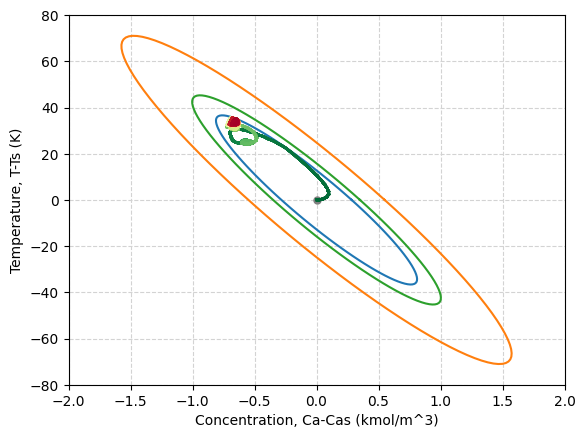

In [252]:
from math import cos, pi, sin

import numpy as np
from matplotlib import pyplot as plt

# plt.rcParams['text.usetex'] = True

A, B, C, F = 1060, 44, 0.52, -85
A2, B2, C2, F2 = 1060, 44, 0.52, -320
A3, B3, C3, F3 = 1060, 44, 0.52, -130
angle = 0.5 * np.arctan(B / (A - C))  # rotation angle
A_prime = A * (cos(angle)) ** 2 + B * cos(angle) * sin(angle) + C * (sin(angle)) ** 2
C_prime = A * (sin(angle)) ** 2 - B * cos(angle) * sin(angle) + C * (cos(angle)) ** 2
a1 = np.sqrt(-F / A_prime)  # radius on the x-axis
b1 = np.sqrt(-F / C_prime)  # radius on the y-axis
#C_A_limit = np.sqrt(a**2 * (cos(angle)) ** 2 + b**2 * (sin(angle)) ** 2)
#T_limit = np.sqrt(a**2 * (sin(angle)) ** 2 + b**2 * (cos(angle)) ** 2)

A_prime2 = (A2 * (cos(angle)) ** 2 + B2 * cos(angle) * sin(angle) + C2 * (sin(angle)) ** 2)
C2_prime = (A2 * (sin(angle)) ** 2 - B2 * cos(angle) * sin(angle) + C2 * (cos(angle)) ** 2)
a2 = np.sqrt(-F2 / A_prime2)  # radius on the x-axis
b2 = np.sqrt(-F2 / C2_prime)  # radius on the y-axis

A_prime3 = (A3 * (cos(angle)) ** 2 + B3 * cos(angle) * sin(angle) + C3 * (sin(angle)) ** 2)
C3_prime = (A3 * (sin(angle)) ** 2 - B3 * cos(angle) * sin(angle) + C3 * (cos(angle)) ** 2)
a3 = np.sqrt(-F3 / A_prime3)  # radius on the x-axis
b3 = np.sqrt(-F3 / C3_prime)  # radius on the y-axis

u, v = 0, 0  # Unstable

t = np.linspace(0, 2 * pi, 100)
Ell = np.array([a1 * np.cos(t), b1 * np.sin(t)])  # u,v removed to keep the same center location
R_rot = np.array([[cos(angle), -sin(angle)], [sin(angle), cos(angle)]])  # 2-D rotation matrix

Ell_rot = np.zeros((2, Ell.shape[1]))
for i in range(Ell.shape[1]):
    Ell_rot[:, i] = np.dot(R_rot, Ell[:, i])


Ell2 = np.array([a2 * np.cos(t), b2 * np.sin(t)])  # u,v removed to keep the same center location
R_rot2 = np.array([[cos(angle), -sin(angle)], [sin(angle), cos(angle)]])  # 2-D rotation matrix

Ell_rot2 = np.zeros((2, Ell2.shape[1]))
for i in range(Ell2.shape[1]):
    Ell_rot2[:, i] = np.dot(R_rot2, Ell2[:, i])

Ell3 = np.array([a3 * np.cos(t), b3 * np.sin(t)])  # u,v removed to keep the same center location
R_rot3 = np.array([[cos(angle), -sin(angle)], [sin(angle), cos(angle)]])  # 2-D rotation matrix

Ell_rot3 = np.zeros((2, Ell3.shape[1]))
for i in range(Ell3.shape[1]):
    Ell_rot3[:, i] = np.dot(R_rot3, Ell3[:, i])


plt.figure()

# Plot the ellipses (these remain static)
plt.plot(u + Ell_rot[0, :], v + Ell_rot[1, :])
plt.plot(u + Ell_rot2[0, :], v + Ell_rot2[1, :])
plt.plot(u + Ell_rot3[0, :], v + Ell_rot3[1, :])
plt.xlim(-2, 2)
plt.ylim(-80, 80)
plt.xticks([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])
plt.yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80])
plt.xlabel("Concentration, Ca-Cas (kmol/m^3)")
plt.ylabel("Temperature, T-Ts (K)")

# Initialize an empty scatter plot for the animation
plt.plot(0,0,'-o',markersize=5,color='grey')
#plt.scatter(setpoint_record[0], setpoint_record[1],c="black" , s=1, zorder=3)
plt.scatter(x_record[0], x_record[1], c=np.linspace(0,1,len(x_record[0])),cmap='RdYlGn_r', vmin=0, vmax=1, s=1, zorder=2)
plt.grid(color="lightgray", linestyle="--", zorder=1)
plt.savefig("ellipseOne.pdf")
plt.show()

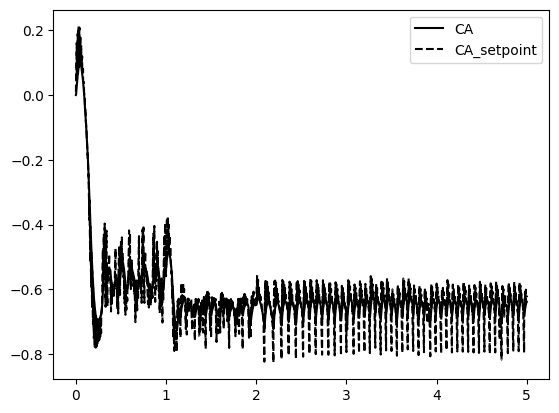

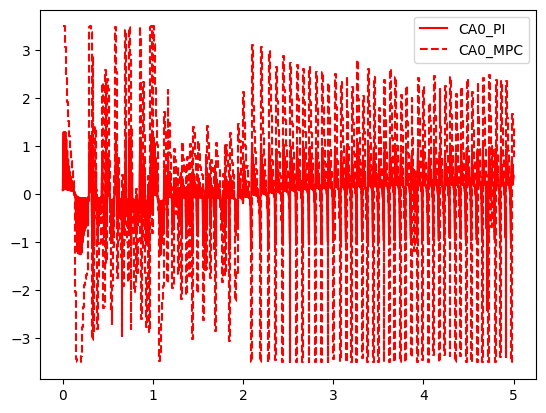

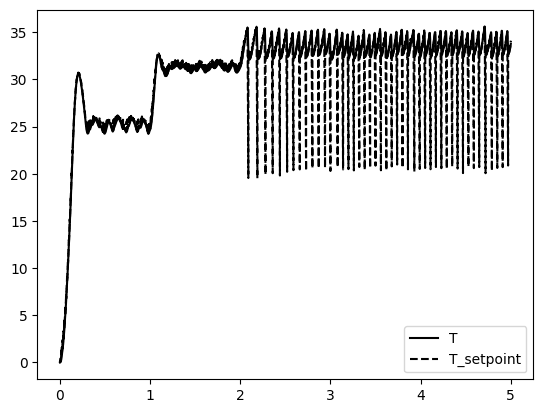

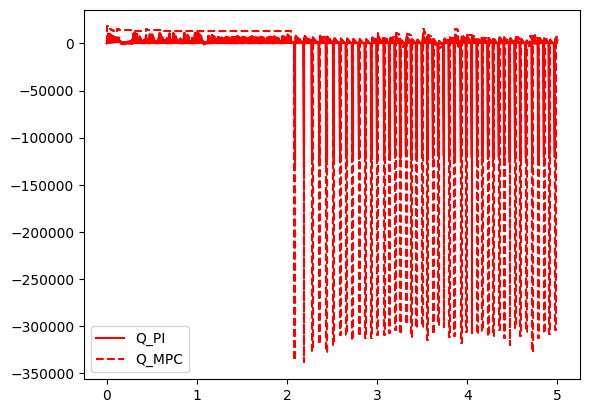

In [253]:
t = np.linspace(0, tFinal, netTimeSteps + 1)
tSetPoint = np.linspace(0, tFinal, netSetPointTimeSteps)
tPIControl = np.linspace(0, tFinal, netPIControlTimeSteps)
tMPControl = np.linspace(0, tFinal, netControlTimeSteps)

plt.figure()
plt.plot(t, x_record[0, :], "k", label="CA")
plt.step(tSetPoint, setpoint_record[0, :], "--k", label="CA_setpoint", where="post")
plt.legend()
plt.show()

plt.figure()
plt.step(tPIControl, u_record[0, :], "r", label="CA0_PI", where="post")
plt.step(tMPControl, uMPC_record[0, :], "--r", label="CA0_MPC", where="post")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, x_record[1, :], "k", label="T")
plt.step(tSetPoint, setpoint_record[1, :], "--k", label="T_setpoint", where="post")
plt.legend()
plt.show()

plt.figure()
plt.step(tPIControl, u_record[1, :], "r", label="Q_PI", where="post")
plt.step(tMPControl, uMPC_record[1, :], "--r", label="Q_MPC", where="post")
plt.legend()
plt.show()

In [254]:
sum(-k0 * np.exp(E_over_R / (x_record[1] + Ts)) * (x_record[0] + CAs) ** 2) * delta

-6914.442745193341

In [255]:
sum(u_record[0])

743.604736328125

In [256]:
(-k0 * np.exp(E_over_R / (x_record[1] + Ts)) * (x_record[0] + CAs) ** 2)[990:]

array([-15.46473125, -15.46956467, -15.47591037, ..., -14.7665214 ,
       -14.77135268, -14.77618334])

In [257]:
x_record[0][:50]

array([0.00000000e+00, 4.39453125e-05, 8.78224663e-05, 1.31631478e-04,
       1.75372365e-04, 2.19045144e-04, 3.29334136e-04, 4.14394644e-04,
       4.99322178e-04, 5.84116770e-04, 6.68778450e-04, 8.57133630e-04,
       9.81649322e-04, 1.10596899e-03, 1.23009268e-03, 1.35402044e-03,
       1.62770979e-03, 1.79031795e-03, 1.95266828e-03, 2.11476083e-03,
       2.27659565e-03, 2.39815425e-03, 2.59872299e-03, 2.79897193e-03,
       2.99890110e-03, 3.19851058e-03, 3.41002281e-03, 3.64583889e-03,
       3.88127642e-03, 4.11633547e-03, 4.35101609e-03, 4.66441365e-03,
       4.93386035e-03, 5.20287144e-03, 5.47144695e-03, 5.73958697e-03,
       6.16131679e-03, 6.46276737e-03, 6.76372679e-03, 7.06419511e-03,
       7.36417240e-03, 7.65831244e-03, 7.99185888e-03, 8.32485812e-03,
       8.65731021e-03, 8.98921522e-03, 9.39659856e-03, 9.75939420e-03,
       1.01215901e-02, 1.04831863e-02])

In [258]:
x_record[1][:50]

array([0.00000000e+00, 4.22754329e-06, 1.07522777e-05, 1.95739102e-05,
       3.06921487e-05, 4.41067019e-05, 3.06970805e-05, 6.58796014e-05,
       1.05547098e-04, 1.49699110e-04, 1.98335175e-04, 3.23895328e-04,
       4.10266590e-04, 5.03253892e-04, 6.02856719e-04, 7.09074557e-04,
       8.82776102e-04, 1.04183941e-03, 1.20961134e-03, 1.38609143e-03,
       1.57127924e-03, 1.69461034e-03, 1.93518592e-03, 2.18657021e-03,
       2.44876292e-03, 2.72176378e-03, 3.01768941e-03, 3.36263500e-03,
       3.72038364e-03, 4.09093534e-03, 4.47429011e-03, 4.84886649e-03,
       5.31794682e-03, 5.80177263e-03, 6.30034433e-03, 6.81366236e-03,
       7.43476967e-03, 8.05024097e-03, 8.68235233e-03, 9.33110468e-03,
       9.99649898e-03, 1.07605415e-02, 1.15298702e-02, 1.23177532e-02,
       1.31241921e-02, 1.39491885e-02, 1.48389826e-02, 1.57823026e-02,
       1.67459778e-02, 1.77300107e-02])

In [259]:
u_record[0][:50]

array([0.08789062, 0.17114258, 0.25170898, 0.33032227, 0.40869141,
       0.48242188, 0.55371094, 0.62255859, 0.69165039, 0.75585938,
       0.82006836, 0.87963867, 0.93896484, 0.99609375, 1.04858398,
       1.10327148, 1.15307617, 1.203125  , 1.25317383, 1.29833984,
       0.1003418 , 0.18359375, 0.2644043 , 0.34277344, 0.41870117,
       0.49243164, 0.5637207 , 0.6328125 , 0.69921875, 0.76098633,
       0.82519531, 0.88476562, 0.94165039, 0.9987793 , 1.0534668 ,
       1.10351562, 1.15332031, 1.20092773, 1.24853516, 1.29370117,
       0.11035156, 0.19580078, 0.27661133, 0.35498047, 0.43115234,
       0.50219727, 0.57373047, 0.64257812, 0.70922852, 0.77319336])

In [260]:
u_record[1][:50]

array([9.76562500e+00, 4.15039062e+01, 9.52148438e+01, 1.68457275e+02,
       2.61230957e+02, 3.75977295e+02, 5.05372314e+02, 6.54298584e+02,
       8.17873535e+02, 9.96097168e+02, 1.19141064e+03, 1.39893164e+03,
       1.62110107e+03, 1.86036060e+03, 2.10938599e+03, 2.37061865e+03,
       2.64161743e+03, 2.92482324e+03, 3.22023657e+03, 3.52541553e+03,
       5.02956787e+02, 9.17996582e+02, 1.35012646e+03, 1.79690552e+03,
       2.25833325e+03, 2.73440991e+03, 3.22513550e+03, 3.73051025e+03,
       4.24320947e+03, 4.77299927e+03, 5.31255493e+03, 5.85943555e+03,
       6.41852368e+03, 6.98737817e+03, 7.56599854e+03, 8.15682690e+03,
       8.75253833e+03, 9.35557471e+03, 9.96593604e+03, 1.05860635e+04,
       5.98276123e+02, 9.86460449e+02, 1.39173511e+03, 1.81654150e+03,
       2.25599658e+03, 2.71254199e+03, 3.18373633e+03, 3.66713818e+03,
       4.16763037e+03, 4.67788867e+03])

In [261]:
setpoint_record[1][:50]

array([9.44794169e-04, 4.17886634e-03, 9.71122098e-03, 1.75512469e-02,
       2.77087235e-02, 4.01938269e-02, 5.50171366e-02, 7.21896422e-02,
       9.17227504e-02, 1.13628292e-01, 1.37918528e-01, 1.64606161e-01,
       1.93704338e-01, 2.25226660e-01, 2.59187194e-01, 2.95600475e-01,
       3.34481521e-01, 3.75845836e-01, 4.19709424e-01, 4.66088798e-01,
       1.81393264e-01, 2.34400635e-01, 2.90059208e-01, 3.48387861e-01,
       4.09406040e-01, 4.73133773e-01, 5.39591682e-01, 6.08800994e-01,
       6.80783557e-01, 7.55561852e-01, 8.33159010e-01, 9.13598822e-01,
       9.96905759e-01, 1.08310498e+00, 1.17222237e+00, 1.26428452e+00,
       1.35931877e+00, 1.45735322e+00, 1.55841676e+00, 1.66253907e+00,
       7.08442466e-01, 7.70985329e-01, 8.36264315e-01, 9.04300498e-01,
       9.75115573e-01, 1.04873186e+00, 1.12517235e+00, 1.20446065e+00,
       1.28662109e+00, 1.37167868e+00])

In [262]:
u = [ 0.          ,0.24609375 ,-3.5   ,      0.19921875 ,-3.5    ,     0.1796875,
 -3.5         ,0.16015625 -3.5         ,0.1484375  ,-3.5,         0.140625,
 -3.5         ,0.1328125  -3.5         ,0.12890625 ,-3.5 ,        0.125,
 -3.5         ,0.12109375 -3.5        , 0.12109375 ,-3.5  ,       0.12109375,
 -3.5         ,0.12109375 -3.5       ,  0.12109375 ,-3.5   ,      0.12109375,
 -3.5         ,0.12109375 -3.5      ,   0.12109375 ,-3.5    ,     0.125,
 -3.5         ,0.125      -3.5     ,    0.125      ,-3.5     ,    0.125,
 -3.5         ,0.125      -3.5    ,     0.125      ,-3.5      ,   0.125,
 -3.5         ,0.125      -3.5   ,      0.125      ,-3.5       ,  0.12109375,
 -3.5         ,0.12109375 -3.5  ,       0.1171875  ,-3.5        , 0.11328125,
 -3.5         ,0.109375   -3.5 ,        0.10546875 ,-3.5         ,0.1015625,
 -3.5         ,0.09375    -3.5,         0.0859375  ,-3.5         ,0.07421875,
 -3.5         ,0.0625     -3.5,         0.05078125, -3.5         ,0.03515625,
 -3.5         ,0.01953125]
CA0_MPC = u[0::NUM_U]
Q_MPC   = u[1::NUM_U]

a = 1060
b = 22
d = 0.52

CA =  -0.5020219934991265
T =  10.057511358981337
encrypted_e1 = []
encrypted_e2 = []
CA_setpoints,T_setpoints = model_makesteps(CA,T,CA0_MPC,Q_MPC,controlStepSize,setpointStepSize)
print(T_setpoints)
# for i in range(timeStepsPerMPC):
#     if i%PIcontrolStepSize == 0:
#         CA   = decrypt(encrypt(CA))
#         T    = decrypt(encrypt(T))
#         setPointIndex = int( i / setpointStepSize )  
#         CA0,Q = solvePI(CA,T,CA_setpoints[setPointIndex],T_setpoints[setPointIndex])
#         CA0   = decrypt(encrypt(CA0))
#         Q     = decrypt(encrypt(Q))
#         u_record[:, [int( i / PIcontrolStepSize )]] = np.array([[CA0], [Q]])
#     CA,T = model_makestep(CA,T,CA0,Q)
#     x_real = np.array([[CA],[T]])

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'size' of type reflected list(float64)<iv=None>
[1m
File "..\..\..\..\AppData\Local\Temp\ipykernel_29624\683018922.py", line 51:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m
[0m[1mDuring: typing of get attribute at C:\Users\arthu\AppData\Local\Temp\ipykernel_29624\683018922.py (51)[0m
[1m
File "..\..\..\..\AppData\Local\Temp\ipykernel_29624\683018922.py", line 51:[0m
[1m<source missing, REPL/exec in use?>[0m


In [ ]:
CA =  -0.5020219934991265
T =  10.057511358981337
a = 1060
b = 22
d = 0.52
((a * CA**2) + 2 * (b * CA * T) + (d * T**2))

In [ ]:
LfV = 0
Lg1V = (2 * a * CA + 2 * b * T) * Coeff1
Lg2V = (2 * d * T + 2 * b * CA) / Coeff3
dV_op2 = LfV + Lg1V * u[0] + Lg2V * u[1]  # (EMPC)Vdot = LfV(x)+LgV(x)*u

kc1 = 2
kc2 = 12000
u11 = kc1 * (0 - CA)
u22 = kc2 * (0 - T)
dV_Pu2 = LfV + Lg1V * u11 + Lg2V * u22  # (PI)Vdot = LfV(x)+LgV(x)*u
bias =  0.000065
min(0, dV_Pu2 - bias) - dV_op2 

In [ ]:
encrypted_e2 = [1,2,3]
currentTime = (np.size(encrypted_e2)-1)*hc
val =sum(encrypted_e2) - encrypted_e2[-1]/2 - encrypted_e2[0]/2
print(val)

4.0


NameError: name 'encrypted_error1' is not defined

In [ ]:
print(u[[0]])
print(type(u[[0]]))

[3.5]
<class 'numpy.ndarray'>
